# Supervised & Unsupervised Topic Modelling

In [1]:
import arxiv
import string
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/66096149/pyldavis-visualization-from-gensim-not-displaying-the-result-in-google-colab
# newer versions of pyLDAvis do not seem to work with Notebooks, install version 2.1.2 specifically if you're running into errors!
import pyLDAvis.gensim
import warnings
import nltk
from typing import List
from wordcloud import WordCloud
from gensim import models, corpora
from collections import Counter

try:
    from nltk.corpus import stopwords
except:
    import nltk
    nltk.download('stopwords')
finally:
    from nltk.corpus import stopwords

/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
# constants
sns.set()
warnings.filterwarnings("ignore") # supresses all warnings

queries = [
    'automl', 'machinelearning', 'data', 'phyiscs','mathematics', 'recommender system', 'nlp', 'neural networks'
]

## Load Data

In [3]:
def search_arxiv(queries: List[str], max_results: int = 100) -> pd.DataFrame:
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.
    
    Args:
        queries: List of strings containing keywords you want to search on Arxiv
        max_results: Integer, representing the maximum number of results you want to 
                     see associated to your search. Default value is 1000, capped at
                     300000.
                            
    Returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed. 
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`
    
    Example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)
    
    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'summary' : res.summary,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)
        
    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year
    
    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d


In [4]:
%%time
# fetch data from arXiv
research_df = search_arxiv(
    queries = queries,
    max_results = 250
)
print(research_df.shape)

(1548, 9)
CPU times: user 1.84 s, sys: 65.2 ms, total: 1.91 s
Wall time: 54.3 s


In [5]:
research_df.head()

,title,date,article_id,url,main_topic,summary,all_topics,authors,year
0,Open Problems in Applied Deep Learning,2023-01-26 18:55:43+00:00,0,http://arxiv.org/pdf/2301.11316v1,cs.LG,This work formulates the machine learning mech...,"[cs.LG, cs.AI, cs.CV, cs.HC, cs.IR]",[Maziar Raissi],2023
1,RF+clust for Leave-One-Problem-Out Performance...,2023-01-23 16:14:59+00:00,1,http://arxiv.org/pdf/2301.09524v2,cs.NE,Per-instance automated algorithm configuration...,"[cs.NE, cs.AI]","[Ana Nikolikj, Carola Doerr, Tome Eftimov]",2023
2,Improvement of Computational Performance of Ev...,2023-01-12 15:59:04+00:00,2,http://arxiv.org/pdf/2301.05102v1,cs.LG,Resource-intensive computations are a major fa...,"[cs.LG, cs.NE, cs.PF]","[Nikolay O. Nikitin, Sergey Teryoshkin, Valeri...",2023
3,Data-driven photometric redshift estimation fr...,2022-12-30 13:01:41+00:00,3,http://arxiv.org/pdf/2212.14668v1,astro-ph.IM,Redshift measurement has always been a constan...,"[astro-ph.IM, astro-ph.CO]","[Felipe M F de Oliveira, Marcelo Vargas dos Sa...",2022
4,Multi-objective Tree-structured Parzen Estimat...,2022-12-13 17:33:02+00:00,4,http://arxiv.org/pdf/2212.06751v1,cs.LG,Hyperparameter optimization (HPO) is essential...,"[cs.LG, cs.AI]","[Shuhei Watanabe, Noow Awad, Masaki Onishi, Fr...",2022


## Data Cleaning

In [6]:
def remove_stopwords(text: str, sw: List[str] = stopwords.words('english')) -> str:
    '''
    This function will remove stopwords from the text
    
    Args:
        text: String of data you want to remove stopwords from
        sw: List of strings indicating the list of stopwords
        
    Returns:
        The input string with the stopwords removed.
    '''
    additional_sw = ['we', 'the', 'this', 'via', 'using']
    sw = sw + additional_sw
    
    text_list = text.split()
    text_list = [word for word in text_list if word.lower() not in sw]
    return ' '.join(text_list)
    
def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
    '''
    This function will remove punctuations from the text.
    
    Args:
        text: String of data you want to remove punctuations from
        punct: String of punctuations
    
    Returns:
        The input string with the punctuations removed.
    '''
    cleaned_text = ''.join([char for char in text if char not in punct])
    return cleaned_text
    
def unicode(text: str) -> str:
    '''
    This function will make all the data unicoded. Meaning Â -> A
    
    Args:
        text: String of data you want to unicode
    
    Returns:
        The input string unicoded.
    '''
    return unidecode.unidecode(text)
    
def clean(text: str) -> str:
    '''
    This method will clean the input text through unidecoding and stopword and punctuation 
    removal.
    
    Args:
        text: String indicating the body of text you want to clean
    
    Returns:
        A string corresponding to the cleaned version of the input string.
    '''
    text = unicode(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text.lower()

In [7]:
%time research_df['cleaned_summary'] = research_df['summary'].apply(lambda x : clean(x))

CPU times: user 295 ms, sys: 3.2 ms, total: 298 ms
Wall time: 335 ms


In [8]:
research_df['cleaned_summary'].values[0]

'work formulates machine learning mechanism bilevel optimization problem inner level optimization loop entails minimizing properly chosen loss function evaluated training data nothing wellstudied training process pursuit optimal model parameters outer level optimization loop less wellstudied involves maximizing properly chosen performance metric evaluated validation data call iteration process pursuing optimal model hyperparameters among many degrees freedom process entails model engineering eg neural network architecture design management experiment tracking dataset versioning augmentation iteration process could automated automatic machine learning automl left intuitions machine learning students engineers researchers regardless route take need reduce computational cost iteration step direct consequence reduce carbon footprint developing artificial intelligence algorithms despite clean unified mathematical formulation iteration step bilevel optimization problem solutions case specifi

In [9]:
%time research_df['summary_word_count'] = research_df['cleaned_summary'].astype('str').str.count(' ')

CPU times: user 5.92 ms, sys: 240 µs, total: 6.16 ms
Wall time: 6.04 ms


In [10]:
research_df.summary_word_count.describe()

count    1548.000000
mean      105.827519
std        35.079621
min        10.000000
25%        83.000000
50%       105.000000
75%       130.000000
max       196.000000
Name: summary_word_count, dtype: float64

1548 documents in total
698 documents have fewer than 100 words
45.1% documents have fewer than 100 words


Text(0.5, 0, 'Word_count')

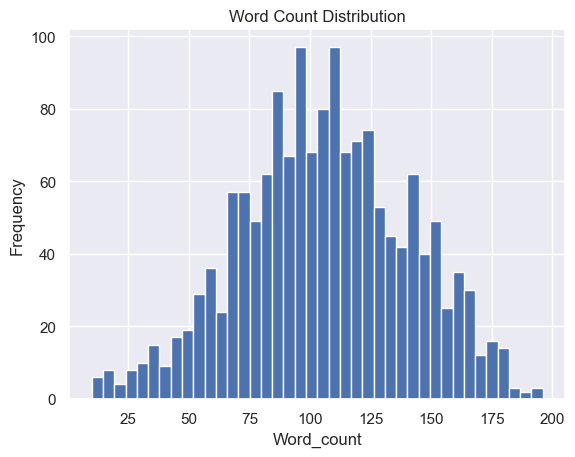

In [11]:
# word count distribution
N = 100
print('{} documents in total'.format(research_df.shape[0]))
print('{} documents have fewer than {N} words'.format(research_df[research_df.summary_word_count<=N].shape[0], N = N))
print('{}% documents have fewer than {N} words'.format(round(research_df[research_df.summary_word_count<=N].shape[0]/research_df.shape[0]*100, 1), N = N))

ax = research_df.summary_word_count.plot.hist(bins=40)
ax.set_title("Word Count Distribution")
ax.set_xlabel('Word_count')

# Unsupervised Learning - LDA

In [12]:
article_summaries = research_df['cleaned_summary'].values
article_summaries = [[word for word in nltk.word_tokenize(article)] for article in article_summaries]

In [13]:
# Create a dictionary of all the words in the dataset
dictionary = corpora.Dictionary(article_summaries)

# Create a corpus
corpus = [dictionary.doc2bow(article) for article in article_summaries]

In [14]:
%%time
# Create an LDA model
lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20)

CPU times: user 14.1 s, sys: 61.6 ms, total: 14.1 s
Wall time: 14.2 s


## Visualization

In [15]:
lda_vis = pyLDAvis.gensim.prepare(
    lda,
    corpus, 
    dictionary=lda.id2word,
    mds='mmds',
    sort_topics=False
)

/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/vatsalpatel/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the 

In [16]:
pyLDAvis.display(lda_vis)

## Word Cloud

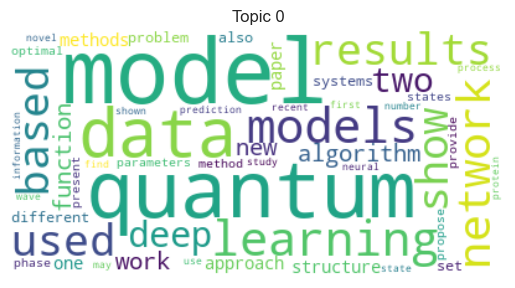

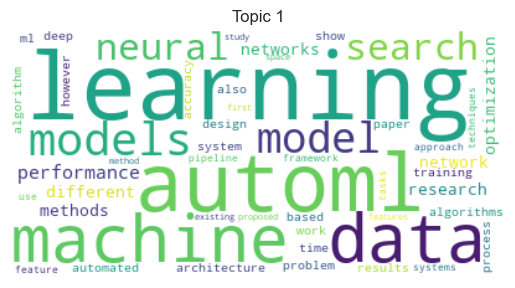

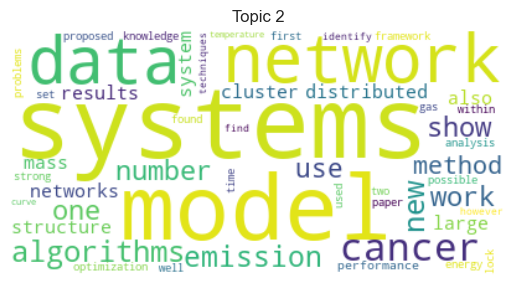

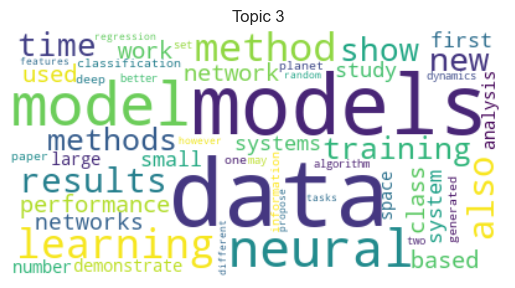

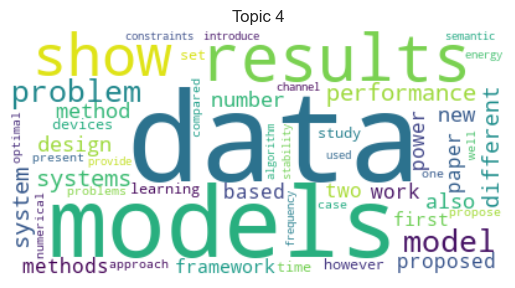

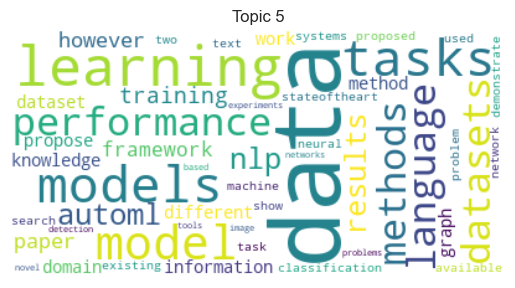

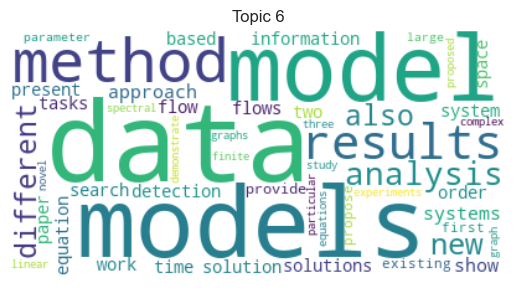

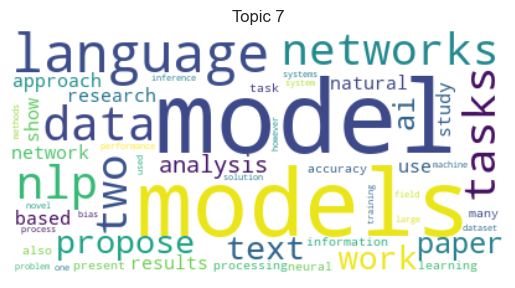

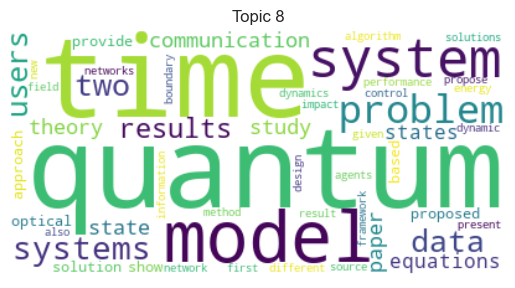

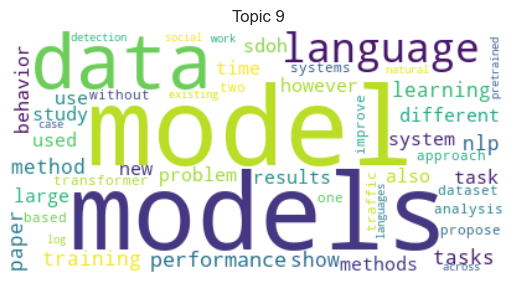

In [17]:
def create_wordcloud(model: models.LdaModel, topic: int):
    '''
    This class will generate a word cloud given an LDA Model and the topic.
    
    Args:
        mdl: LDA Model
        topic: Integer representing the topic
    '''
    text = {word: value for word, value in model.show_topic(topic, topn=50)}
    wc = WordCloud(
        background_color="white",
        max_words=1000
    )
    wc.generate_from_frequencies(text)
    plt.clf()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()
    
for i in range (0,10):
    create_wordcloud(lda, topic=i)

## Topic Analysis

In [18]:
def top_relevant_topics_per_article(mdl: models.LdaModel, corpus: list, articles: list, th: int) -> pd.DataFrame:
    """This method will create a dataframe which identifies the top relevant topics
    greater than a threshold for a given article.
    
    Args:
        mdl: LDA model
        corpus: List of tuples holding the corpus
        articles: List of strings with the article summaries
        th: Integer indicating the threshold of probability the topic must be greater than
    
    Returns:
        A DataFrame with the columns "articl", "topic" and "probability".
    """
    relevant_df = []
    
    for i, article in enumerate(articles):
        topics = mdl.get_document_topics(corpus[i])
        topics = sorted(topics, key = lambda x : x[1], reverse = True)[:5]
        for topic in topics:
            proba = topic[1]
            if proba > th:
                data = {
                    "article" : article,
                    "topic" : topic[0],
                    "proba" : proba
                }
                relevant_df.append(pd.DataFrame([data]))
    return pd.concat(relevant_df)

In [19]:
th = 0.3
articles = [' '.join(article) for article in article_summaries]
rel_df = top_relevant_topics_per_article(lda, corpus, articles, th)

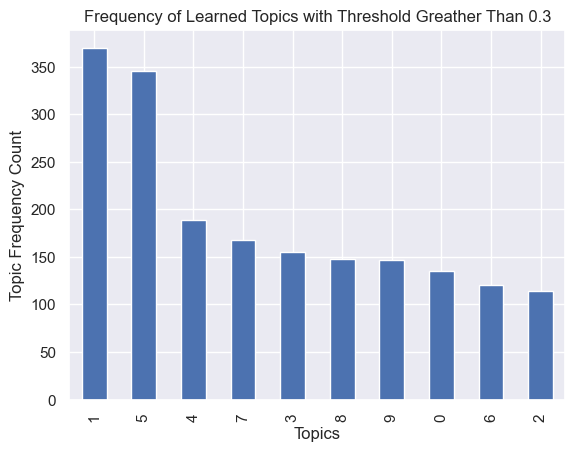

In [20]:
plt.clf()
rel_df['topic'].value_counts().plot(kind = 'bar')
plt.xlabel("Topics")
plt.ylabel("Topic Frequency Count")
plt.title("Frequency of Learned Topics with Threshold Greather Than {th}".format(th=th))
plt.show()

In [21]:
list_sorted_token = sorted(lda.id2word.cfs.items(), key=lambda item: item[1], reverse=True)

term_freq_df = pd.DataFrame(
    data={
        'term' : [lda.id2word[key] for (key, value) in list_sorted_token],
        'term_freq': [value for (key, value) in list_sorted_token]
    }
)

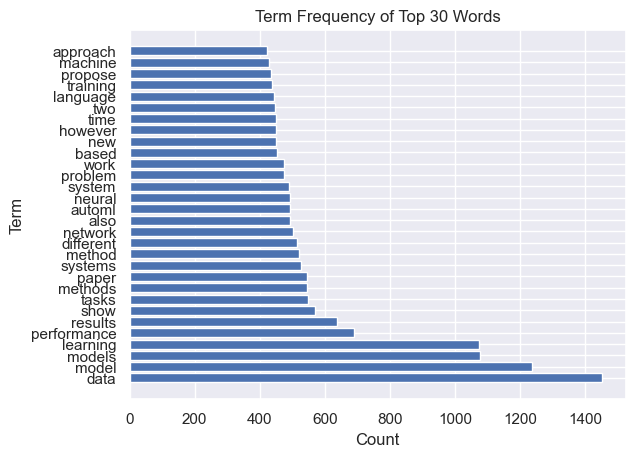

In [22]:
N = 30
plt.clf()
plt.barh(
    term_freq_df.head(N)['term'],
    term_freq_df.head(N)['term_freq']
)
plt.xlabel("Count")
plt.ylabel("Term")
plt.title("Term Frequency of Top {N} Words".format(N = N))
plt.show()

In [23]:
def topic_keywords(mdl: models.LdaModel, research_df: pd.DataFrame, corpus: list, th: int) -> pd.DataFrame:
    '''
    This method will generate a DataFrame which indicates the topic, number of documents 
    associated to that topic and the keywords based on TF-IDF of the corpus.
    
    Args:
        mdl: LDA model
        corpus: List of tuples holding the corpus
        research_df: DataFrame which holds the research data
        th: Integer indicating the threshold of probability the topic must be greater than
        
    Returns:
        A DataFrame with the columns "topic", "n_documents", "keywords"
    '''
    tf_idf = models.TfidfModel(corpus=corpus)
    
    topics_prob_df = pd.DataFrame(columns=['topic_'+str(i) for i in range(lda.num_topics)])

    for index, row in enumerate(mdl.get_document_topics(corpus, minimum_probability=0.0)):
        _, prob = zip(*row)
        topics_prob_df.loc[index] = list(prob)
    
    topics_df = research_df.reset_index(drop=True).merge(
            topics_prob_df, how='left', right_index=True, left_index=True
    )
    
    res = pd.DataFrame(index = ['topic_' + str(i) for i in range(lda.num_topics)])

    res['n_documents'] = topics_prob_df[topics_prob_df>th].count(axis = 0)
    res['keywords'] = [
        ' '.join([word for word, prop in topic[1]]) for topic in lda.show_topics(
            num_topics=mdl.num_topics, 
            num_words=50, formatted=False
        )
    ]
    return res

In [24]:
topic_keywords(lda, research_df, corpus, th)

,n_documents,keywords
topic_0,135,model quantum data learning models network res...
topic_1,370,learning automl data machine models model sear...
topic_2,114,systems model network data cancer algorithms n...
topic_3,155,data models model neural learning method also ...
topic_4,189,data models results show problem model perform...
topic_5,345,data learning models tasks model performance d...
topic_6,121,data models model method results analysis new ...
topic_7,168,model models language data nlp two networks ta...
topic_8,148,quantum time model system problem systems data...
topic_9,147,model models data language performance nlp tas...


# Supervised Learning - Binary Classification

In [25]:
topics_dct = {
    'machinelearning': [
        'machinelearning', 'clustering', 'classification', 'regression', 'supervised machine learning', 'unsupervised machine learning'
    ],
    'mathematics': [
        'mathematics', 'graph theory', 'combinatorics', 'calculus', 'linear algebra', 'probability', 'statistics', 'trigonometry', 'topology', 
        'differential equations', 'differentiate', 'algebra'
    ],
    'nlp': [
        'natural language', 'topic modelling', 'sentiment analysis', 'translation', 'chat bot', 'text analysis', 'text mining', 'semantic analysis',
        'summarization', 'linguistic processing', 'language recognition', 'text processing', 'language models', 'linguistic', 'sequencetosequence',
        'neural machcine translation', 'word embeddings', 'word2vec'
    ]
}

In [26]:
kw_df = research_df[['article_id', 'url', 'all_topics', 'cleaned_summary']].copy()

In [27]:
all_kws = list(topics_dct.values())

In [28]:
all_kws = all_kws[0] + all_kws[1] + all_kws[2]

In [29]:
kw_df['kw_frequency'] = kw_df['cleaned_summary'].apply(lambda x: {k: v for k, v in Counter(x.split()).items() if k in all_kws} or 0)

In [30]:
kw_df[kw_df['kw_frequency'] != 0]['kw_frequency'].astype('str').value_counts()

{'classification': 1}                                   94
{'classification': 2}                                   28
{'probability': 1}                                      26
{'statistics': 1}                                       19
{'regression': 1}                                       17
                                                        ..
{'machinelearning': 1, 'regression': 1}                  1
{'statistics': 1, 'probability': 3}                      1
{'mathematics': 1, 'statistics': 1, 'regression': 1}     1
{'translation': 2, 'probability': 2}                     1
{'classification': 2, 'machinelearning': 1}              1
Name: kw_frequency, Length: 83, dtype: int64

## Generate Labels

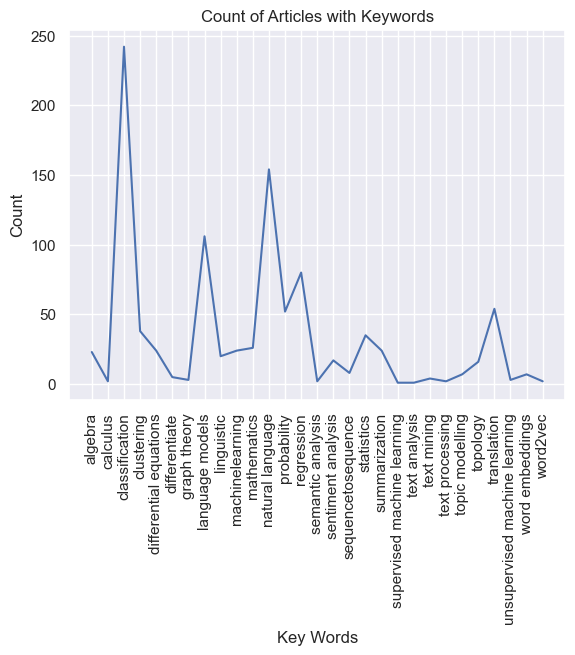

In [31]:
def kw_frequency(df: pd.DataFrame, col: str, all_kws: list) -> pd.DataFrame:
    '''
    This method will take the input dataframe, scan through the text in the column and count 
    the occurrences of the keywords. It will create new columns on the input dataframe where
    each column corresponds to a keyword from all_kws.
    
    Args:
        df: DataFrame holding the text column you want to scan over
        col: String corresponding to a column name in the input df
        all_kws: List of unique keywords you want to count in the column
    
    Returns:
        A DataFrame with additional columns corresponding to the keywords in all_kws.
    '''
    freq_df = (
        df[col].str.extractall(r'\b({})\b'.format('|'.join(all_kws)))
               .groupby(level=0)[0]
               .value_counts()
               .unstack()
               .reindex(df.index)
               .rename_axis(None, axis=1)
    ).fillna(0)
    return freq_df

freq_ = kw_frequency(df = research_df, col = 'cleaned_summary', all_kws = all_kws).sum(axis = 0)
plt.clf()
plt.plot(freq_.index, freq_.values)
plt.title("Count of Articles with Keywords")
plt.xticks(rotation = 90)
plt.xlabel("Key Words")
plt.ylabel("Count")
plt.show()

In [32]:
def generate_labels(topics_dct: dict, df: pd.DataFrame, col: str) -> pd.DataFrame:
    '''
    This method will generate binary labels associated with each topic in topics_dct
    by counting the keyword occurrences associated with that topic.
    
    Args:
        df: DataFrame holding the text column you want to scan over
        col: String corresponding to a column name in the input df
        topics_dct: Dictionary of unique topics and list of keywords you want to count
                    in the column
    
    Returns:
        The input dataframe with additional columns corresponding to the label for each
        topic in topics_dct
    '''    
    for topic,kw in topics_dct.items():
        # count the occurrences of. the keywords in the summary
        df[topic + '_label'] = df[col].apply(lambda x : [1 for word, count in Counter(x.split()).items() if word in kw] or np.nan)

        # generate binary classification -- 1 if the keyword was in the article, 0 otherwise
        df[topic + '_label'] = df[topic + '_label'].apply(lambda x : [1 if isinstance(x, list) else np.nan][0])
        df[topic + '_label'] = df[topic + '_label'].fillna(0)
    return df
kw_df = generate_labels(topics_dct, kw_df, 'cleaned_summary')

In [33]:
kw_df.head()

,article_id,url,all_topics,cleaned_summary,kw_frequency,machinelearning_label,mathematics_label,nlp_label
0,0,http://arxiv.org/pdf/2301.11316v1,"[cs.LG, cs.AI, cs.CV, cs.HC, cs.IR]",work formulates machine learning mechanism bil...,0,0.0,0.0,0.0
1,1,http://arxiv.org/pdf/2301.09524v2,"[cs.NE, cs.AI]",perinstance automated algorithm configuration ...,0,0.0,0.0,0.0
2,2,http://arxiv.org/pdf/2301.05102v1,"[cs.LG, cs.NE, cs.PF]",resourceintensive computations major factor li...,0,0.0,0.0,0.0
3,3,http://arxiv.org/pdf/2212.14668v1,"[astro-ph.IM, astro-ph.CO]",redshift measurement always constant need mode...,"{'regression': 1, 'probability': 1}",1.0,1.0,0.0
4,4,http://arxiv.org/pdf/2212.06751v1,"[cs.LG, cs.AI]",hyperparameter optimization hpo essential bett...,0,0.0,0.0,0.0


In [34]:
for col in ['machinelearning_label', 'mathematics_label', 'nlp_label']:
    print(col, kw_df[col].sum())

machinelearning_label 227.0
mathematics_label 112.0
nlp_label 54.0


## Train Model

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [36]:
kw_df.shape

(1548, 8)

In [37]:
kw_df.head()

,article_id,url,all_topics,cleaned_summary,kw_frequency,machinelearning_label,mathematics_label,nlp_label
0,0,http://arxiv.org/pdf/2301.11316v1,"[cs.LG, cs.AI, cs.CV, cs.HC, cs.IR]",work formulates machine learning mechanism bil...,0,0.0,0.0,0.0
1,1,http://arxiv.org/pdf/2301.09524v2,"[cs.NE, cs.AI]",perinstance automated algorithm configuration ...,0,0.0,0.0,0.0
2,2,http://arxiv.org/pdf/2301.05102v1,"[cs.LG, cs.NE, cs.PF]",resourceintensive computations major factor li...,0,0.0,0.0,0.0
3,3,http://arxiv.org/pdf/2212.14668v1,"[astro-ph.IM, astro-ph.CO]",redshift measurement always constant need mode...,"{'regression': 1, 'probability': 1}",1.0,1.0,0.0
4,4,http://arxiv.org/pdf/2212.06751v1,"[cs.LG, cs.AI]",hyperparameter optimization hpo essential bett...,0,0.0,0.0,0.0


In [47]:
%%time
text_col = 'cleaned_summary'
topic_models = {}

for topic in topics_dct.keys():
    print(topic)
    label_col = topic + '_label'
    positive_label_count = kw_df[label_col].sum()
    negative_label_count = kw_df.shape[0] - positive_label_count
    
    positive_labels = kw_df[kw_df[label_col] == 1].sample(round(positive_label_count * 0.8)).copy()
    negative_labels = kw_df[kw_df[label_col] == 0].sample(round(negative_label_count * 0.8)).copy()
    training_df = pd.concat([positive_labels, negative_labels])
    holdout_df = kw_df[~kw_df['url'].isin(training_df['url'])]
    print("Training Data Shape: ", training_df.shape)
    print("Holdout Data Shape: ", holdout_df.shape)
    print(training_df[label_col].value_counts())
    print(holdout_df[label_col].value_counts())
    
    # create the sklearn pipeline
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', GradientBoostingClassifier())
    ])
    pipe.fit(training_df[text_col], training_df[label_col])
    scores = cross_val_score(pipe, training_df[text_col], training_df[label_col], cv=4)
    print("Mean CV Score: ", scores.mean())
    topic_models[topic] = {
        'model' : pipe,
        'training_data' : training_df,
        'holdout_data' : holdout_df
    }

machinelearning
Training Data Shape:  (1239, 8)
Holdout Data Shape:  (245, 8)
0.0    1057
1.0     182
Name: machinelearning_label, dtype: int64
0.0    209
1.0     36
Name: machinelearning_label, dtype: int64
Mean CV Score:  1.0
mathematics
Training Data Shape:  (1239, 8)
Holdout Data Shape:  (250, 8)
0.0    1149
1.0      90
Name: mathematics_label, dtype: int64
0.0    235
1.0     15
Name: mathematics_label, dtype: int64
Mean CV Score:  0.9991935483870968
nlp
Training Data Shape:  (1238, 8)
Holdout Data Shape:  (243, 8)
0.0    1195
1.0      43
Name: nlp_label, dtype: int64
0.0    234
1.0      9
Name: nlp_label, dtype: int64
Mean CV Score:  0.9991935483870968
CPU times: user 18.5 s, sys: 168 ms, total: 18.6 s
Wall time: 18.7 s


In [39]:
topic_models['machinelearning']['model']

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', GradientBoostingClassifier())])

## Evaluation

In [43]:
for topic, mdl_dct in topic_models.items():
    print(topic)
    mdl = mdl_dct['model']
    holdout_df = mdl_dct['holdout_data']
    train_df = mdl_dct['training_data']
    holdout_df['prediction'] = mdl.predict(holdout_df[text_col])
    correct_predictions = holdout_df[holdout_df['prediction'] == holdout_df[topic + '_label']]
    print("Accuracy on Holdout Data : ", correct_predictions.shape[0] / holdout_df.shape[0])
    # cv_scores = cross_val_score(mdl, train_df[text_col], train

machinelearning
Accuracy on Holdout Data :  1.0
mathematics
Accuracy on Holdout Data :  1.0
nlp
Accuracy on Holdout Data :  1.0


---